In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e3/sample_submission.csv
/kaggle/input/playground-series-s4e3/train.csv
/kaggle/input/playground-series-s4e3/test.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import StandardScaler 
import optuna
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# ***LOADING THE DATA***

In [3]:
sample_sub = pd.read_csv('/kaggle/input/playground-series-s4e3/sample_submission.csv')
train = pd.read_csv('/kaggle/input/playground-series-s4e3/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e3/test.csv')

In [4]:
sample_sub.head(3)

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1,19220,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2,19221,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [5]:
train.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,584,590,909972,909977,16,8,5,2274,113,...,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,1,808,816,728350,728372,433,20,54,44478,70,...,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,...,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,3,781,789,3353146,3353173,210,16,29,3202,114,...,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,4,1540,1560,618457,618502,521,72,67,48231,82,...,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1


In [6]:
test.head(2)

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,19219,1015,1033,3826564,3826588,659,23,46,62357,67,...,0.0095,0.5652,1.0,1.0,2.8410,1.1139,1.6628,0.6727,-0.2261,0.9172
1,19220,1257,1271,419960,419973,370,26,28,39293,92,...,0.0047,0.2414,1.0,1.0,2.5682,0.9031,1.4472,0.9063,-0.1453,0.9104


# ***DATA SUMMARY***

In [7]:
class summary:
    def __init__(self, train):
        self.train = train
    def data_set(self):
        duplicate = self.train.duplicated().any()
        if duplicate == 'True':
            self.train.drop_duplicates(inplace=True)
            self.train.reset_index(drop=True)
        null = self.train.isna().sum().any()
        total_missing = self.train.isnull().sum().sum()
        data_type = self.train.dtypes
        shapes = self.train.shape
        return f"Duplicate: {duplicate}\nNull: {null}\nMissing_value: {total_missing}\nTypes: {data_type}\nShape: {shapes}"

In [8]:
print(summary(train).data_set())

Duplicate: False
Null: False
Missing_value: 0
Types: id                         int64
X_Minimum                  int64
X_Maximum                  int64
Y_Minimum                  int64
Y_Maximum                  int64
Pixels_Areas               int64
X_Perimeter                int64
Y_Perimeter                int64
Sum_of_Luminosity          int64
Minimum_of_Luminosity      int64
Maximum_of_Luminosity      int64
Length_of_Conveyer         int64
TypeOfSteel_A300           int64
TypeOfSteel_A400           int64
Steel_Plate_Thickness      int64
Edges_Index              float64
Empty_Index              float64
Square_Index             float64
Outside_X_Index          float64
Edges_X_Index            float64
Edges_Y_Index            float64
Outside_Global_Index     float64
LogOfAreas               float64
Log_X_Index              float64
Log_Y_Index              float64
Orientation_Index        float64
Luminosity_Index         float64
SigmoidOfAreas           float64
Pastry                 

In [9]:
print(summary(test).data_set())

Duplicate: False
Null: False
Missing_value: 0
Types: id                         int64
X_Minimum                  int64
X_Maximum                  int64
Y_Minimum                  int64
Y_Maximum                  int64
Pixels_Areas               int64
X_Perimeter                int64
Y_Perimeter                int64
Sum_of_Luminosity          int64
Minimum_of_Luminosity      int64
Maximum_of_Luminosity      int64
Length_of_Conveyer         int64
TypeOfSteel_A300           int64
TypeOfSteel_A400           int64
Steel_Plate_Thickness      int64
Edges_Index              float64
Empty_Index              float64
Square_Index             float64
Outside_X_Index          float64
Edges_X_Index            float64
Edges_Y_Index            float64
Outside_Global_Index     float64
LogOfAreas               float64
Log_X_Index              float64
Log_Y_Index              float64
Orientation_Index        float64
Luminosity_Index         float64
SigmoidOfAreas           float64
dtype: object
Shape: (1

# ***EDA AND SPLITTING THE DATASET***

In [10]:
train.drop('id', axis=1, inplace=True)

In [11]:
train.head(2)

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,584,590,909972,909977,16,8,5,2274,113,140,...,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,808,816,728350,728372,433,20,54,44478,70,111,...,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1


In [12]:
train.describe().transpose()[['mean', 'std']]

,mean,std
X_Minimum,7.098547e+02,5.315442e+02
X_Maximum,7.538576e+02,4.998366e+02
Y_Minimum,1.849756e+06,1.903554e+06
Y_Maximum,1.846605e+06,1.896295e+06
Pixels_Areas,1.683988e+03,3.730320e+03
X_Perimeter,9.565466e+01,1.778214e+02
Y_Perimeter,6.412410e+01,1.010542e+02
Sum_of_Luminosity,1.918467e+05,4.420247e+05
Minimum_of_Luminosity,8.480842e+01,2.880034e+01
Maximum_of_Luminosity,1.286474e+02,1.419698e+01


In [13]:
test.drop('id', axis=1, inplace=True)

In [14]:
#creating a target_sum column for EDA purpose '
train['target_sum'] = train[['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']].idxmax(axis=1)

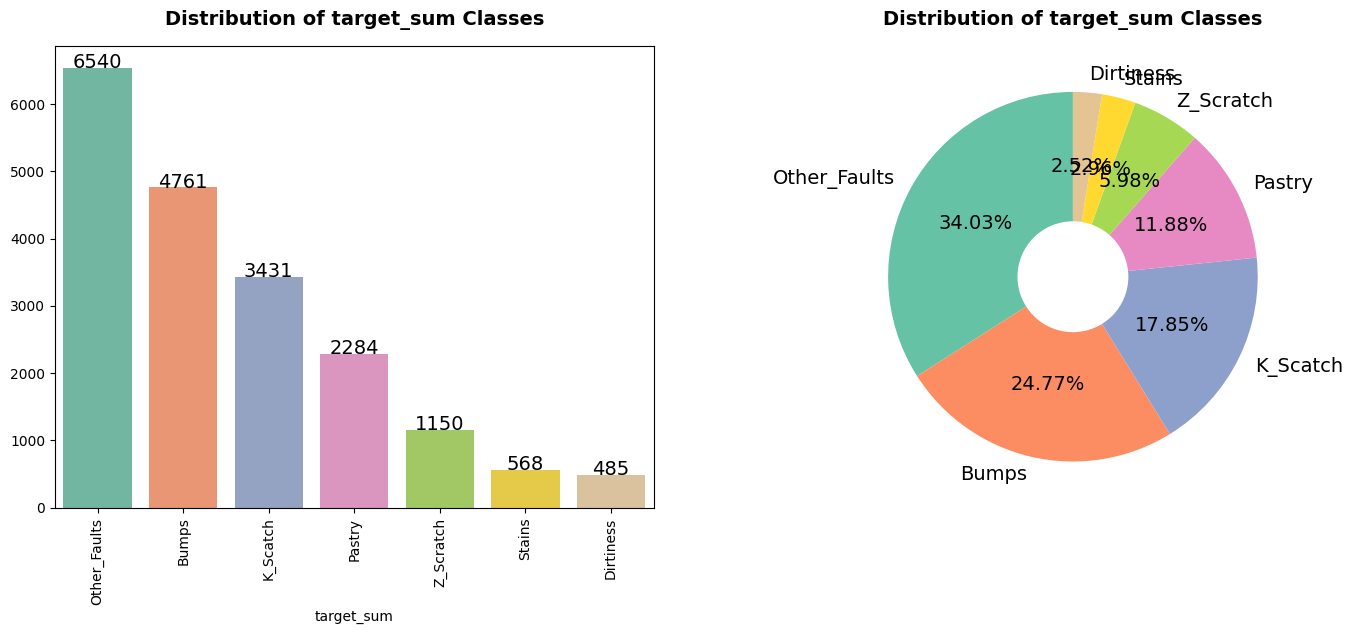

In [15]:
# Visualization to show distribution of target_sum classes
plt.figure(figsize=(17, 6))
plt.subplot(1, 2, 1)
target_sum_counts = train["target_sum"].value_counts()
sns.barplot(x=target_sum_counts.index, y=target_sum_counts.values, palette='Set2')
plt.title("Distribution of target_sum Classes", fontweight="black", size=14, pad=15)
for i, v in enumerate(target_sum_counts.values):
    plt.text(i, v, v, ha="center", fontsize=14)
plt.xticks(rotation=90)
# Visualization to show distribution of target_sum classes in percentage
plt.subplot(1, 2, 2)
colors = sns.color_palette('Set2', len(target_sum_counts))
plt.pie(target_sum_counts, labels=target_sum_counts.index, autopct="%.2f%%", textprops={"size": 14},
                colors=colors, startangle=90)
center_circle = plt.Circle((0, 0), 0.3, fc='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)
plt.title("Distribution of target_sum Classes", fontweight="black", size=14, pad=15)
plt.show()
        

In [16]:
num_feat = ['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
                      'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity', 'Minimum_of_Luminosity',
                      'Maximum_of_Luminosity', 'Length_of_Conveyer', 'TypeOfSteel_A300',
                      'TypeOfSteel_A400', 'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index',
                      'Square_Index', 'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index',
                      'Outside_Global_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index',
                      'Orientation_Index', 'Luminosity_Index', 'SigmoidOfAreas']

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

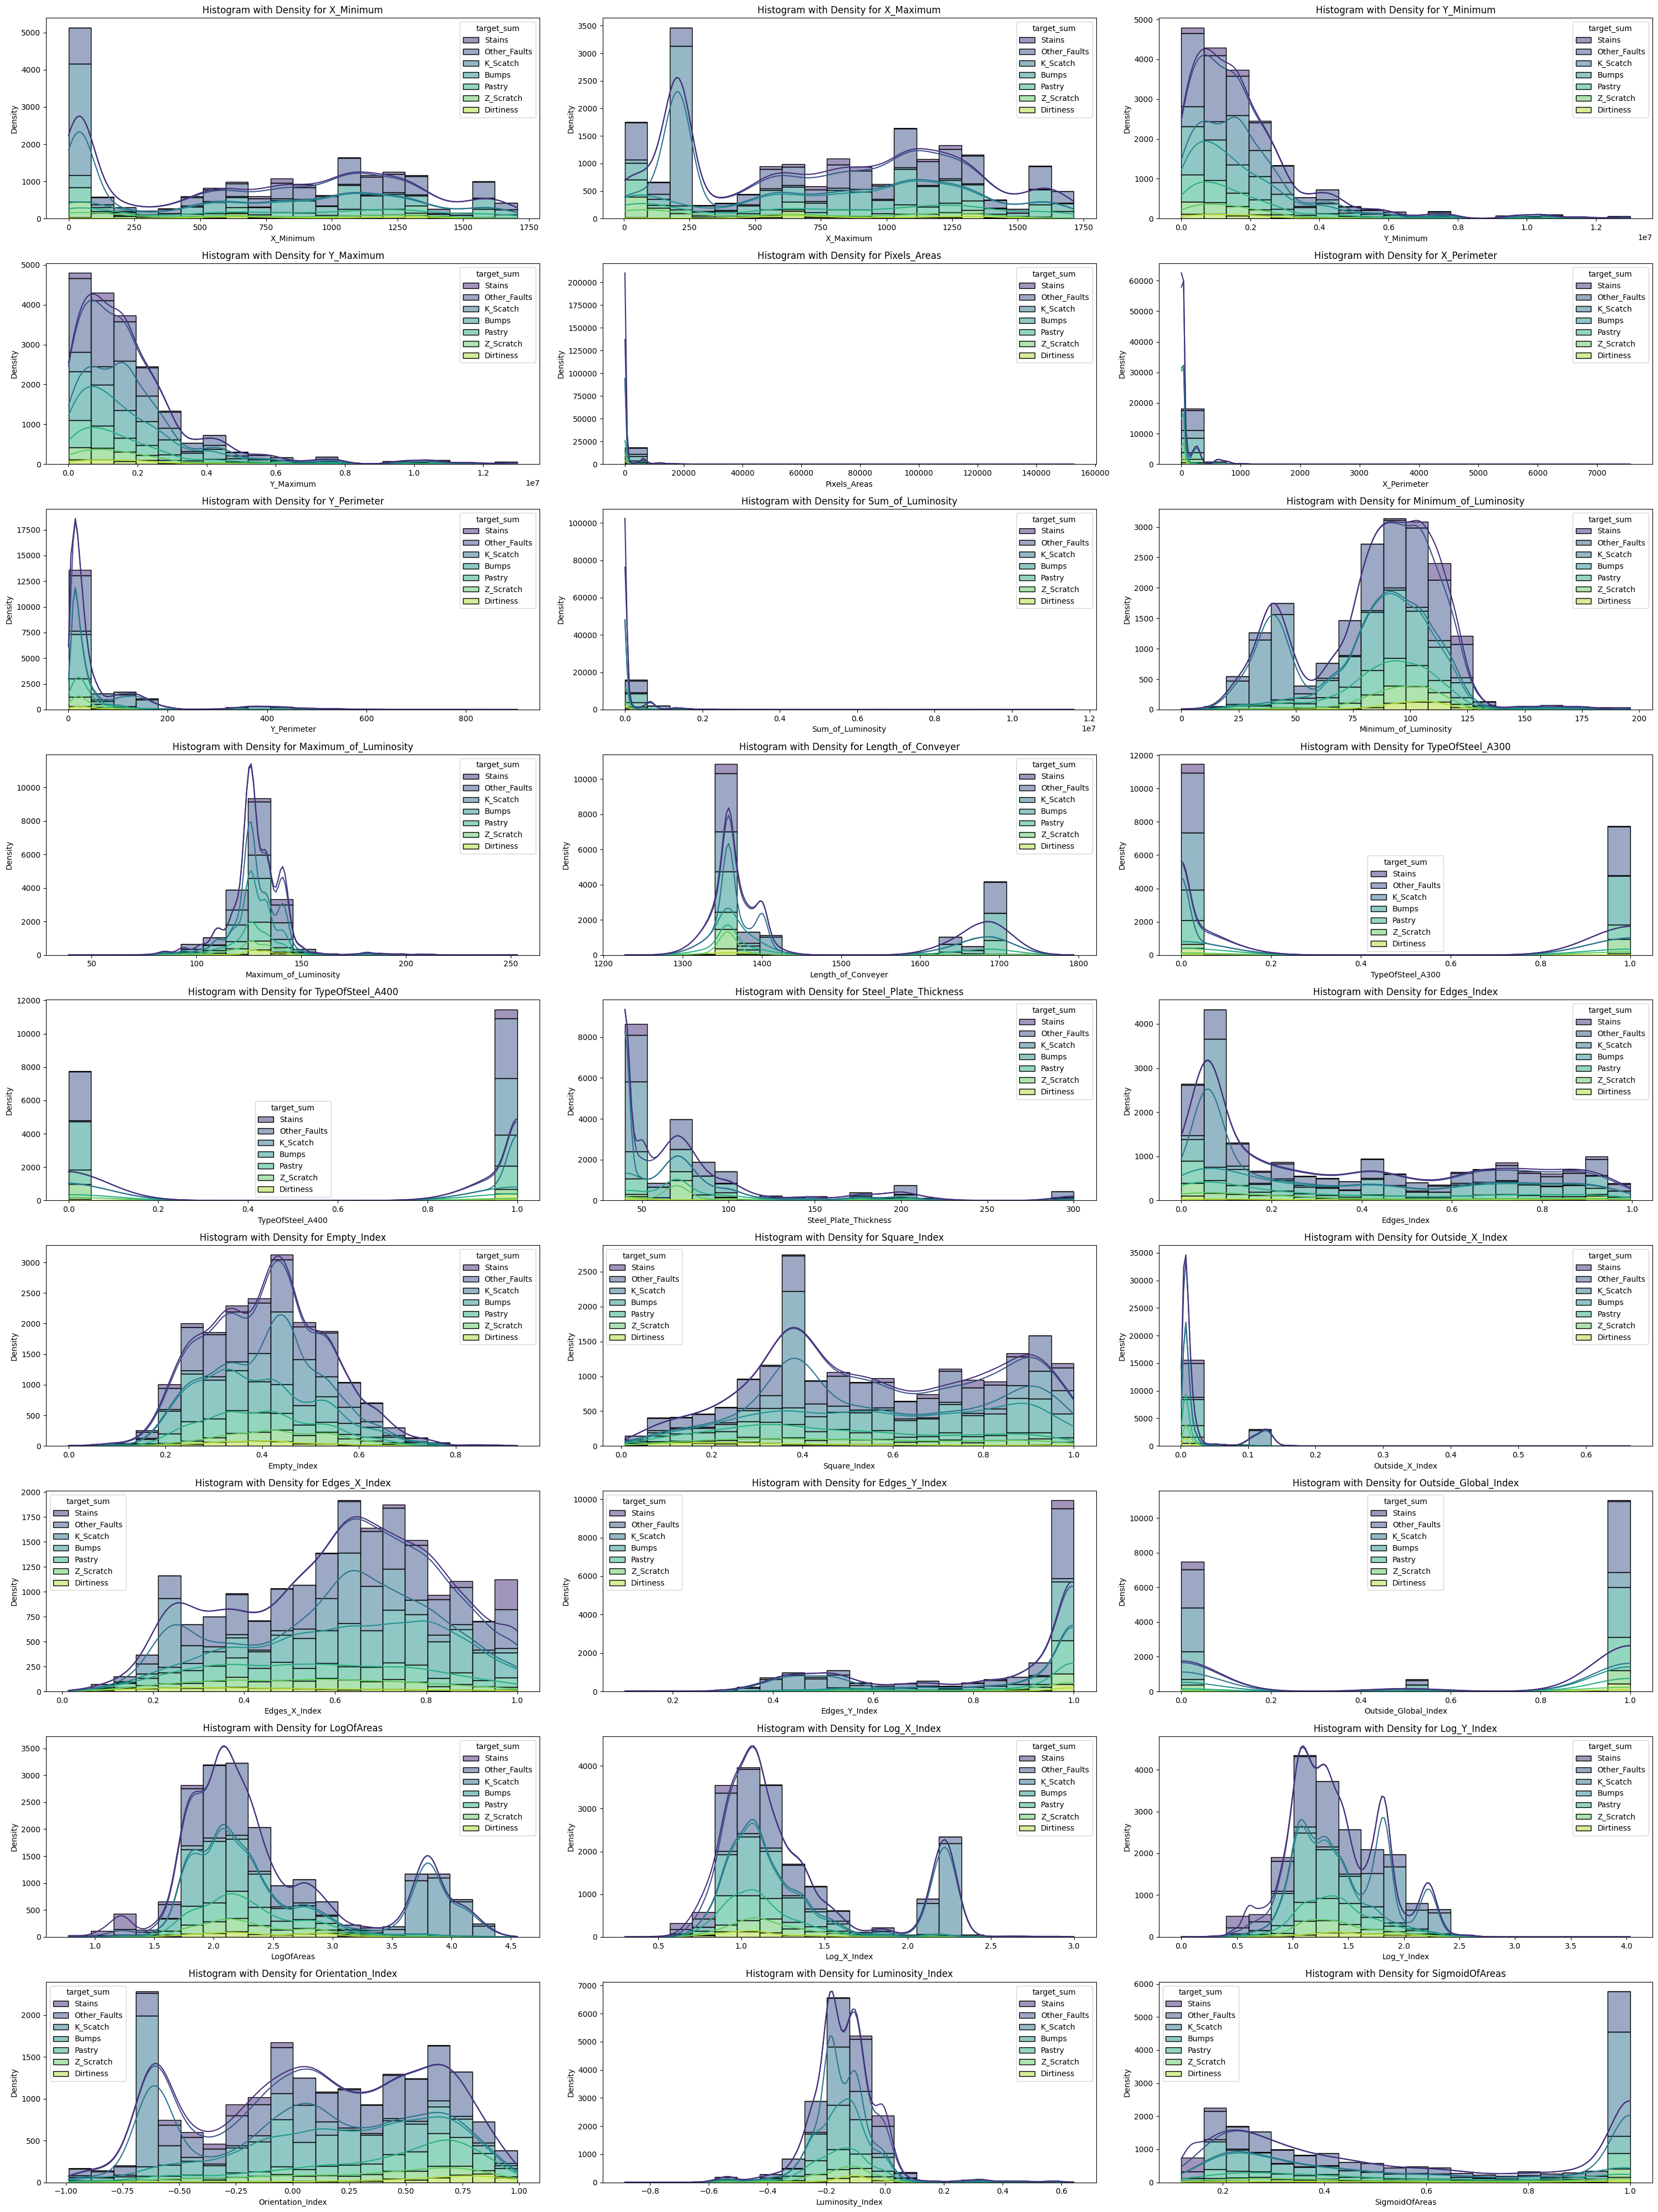

In [17]:
# Set the figure size and arrange plots horizontally in pairs
fig, axes = plt.subplots(nrows=(len(num_feat) + 2) // 3, ncols=3, figsize=(30, 40))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Loop through the selected columns and create histograms with density
for i, col in enumerate(num_feat):
    sns.histplot(data=train, x=col, hue='target_sum', multiple="stack", bins=20, kde=True, palette='viridis', ax=axes[i])
    axes[i].set_title(f'Histogram with Density for {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')
    
# Remove any empty subplots if the number of columns is odd
if len(num_feat) % 3 != 0:
    for j in range(len(num_feat) % 3, 3):
        fig.delaxes(axes[-j - 1])

plt.tight_layout()
plt.show()

In [18]:
def transform(X):
    eps=1e-5
    X['Sum_of_Luminosity']=np.log(X['Sum_of_Luminosity']+eps)
    X['Pixels_Areas']=np.log(X['Pixels_Areas']+eps)
    X['X_Perimeter']=np.log(X['X_Perimeter']+eps)
    X['Steel_Plate_Thickness']=np.log(X['Steel_Plate_Thickness']+eps)
    X['Y_Perimeter']=np.log(X['Y_Perimeter']+eps)
    X['Outside_X_Index']=np.log(X['Outside_X_Index']+eps)
    X['Y_Minimum']=np.log(X['Y_Minimum']+eps)
    X['Y_Maximum']=np.log(X['Y_Maximum']+eps)
    return X

In [19]:
transform(train)

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,target_sum
0,584,590,13.721169,13.721175,2.772589,2.079443,1.609440,7.729296,113,140,...,-0.0104,0.1417,0,0,0,1,0,0,0,Stains
1,808,816,13.498537,13.498567,6.070738,2.995733,3.988984,10.702750,70,111,...,-0.2997,0.9491,0,0,0,0,0,0,1,Other_Faults
2,39,192,14.609442,14.609473,9.340315,6.558198,6.040255,14.086599,29,141,...,-0.0944,1.0000,0,0,1,0,0,0,0,K_Scatch
3,781,789,15.025410,15.025418,5.347108,2.772589,3.367296,8.071531,114,134,...,-0.0402,0.4025,0,0,1,0,0,0,0,K_Scatch
4,1540,1560,13.334983,13.335056,6.255750,4.276666,4.204693,10.783757,82,111,...,-0.2455,0.9998,0,0,0,0,0,0,1,Other_Faults
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19214,749,757,11.872067,11.872130,2.833214,1.386297,1.386297,7.693026,122,140,...,0.0044,0.2901,0,0,0,1,0,0,0,Stains
19215,723,735,14.727202,14.727207,5.442418,2.833214,3.258097,10.208580,104,133,...,-0.0989,0.5378,0,0,0,0,0,0,1,Other_Faults
19216,6,31,14.271704,14.271751,6.659294,4.736199,4.584968,11.172011,41,94,...,-0.4283,0.9997,1,0,0,0,0,0,0,Pastry
19217,9,18,14.353857,14.353864,4.836282,2.564950,3.258097,9.602923,88,132,...,-0.1162,0.3509,0,0,0,0,0,0,1,Other_Faults


In [20]:
transform(test)

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,1015,1033,15.157478,15.157484,6.490724,3.135495,3.828642,11.040631,67,127,...,-4.655411,0.5652,1.0000,1.0,2.8410,1.1139,1.6628,0.6727,-0.2261,0.9172
1,1257,1271,12.947915,12.947946,5.913503,3.258097,3.332205,10.578802,92,132,...,-5.358067,0.2414,1.0000,1.0,2.5682,0.9031,1.4472,0.9063,-0.1453,0.9104
2,1358,1372,11.676022,11.676098,5.666427,3.583519,3.465736,10.288274,101,134,...,-4.166270,0.6000,0.7500,0.0,2.4609,1.3222,1.3222,-0.5238,-0.0435,0.6514
3,158,168,12.356280,12.356387,4.382027,2.302586,2.397896,9.057888,107,140,...,-5.596723,0.8000,1.0000,1.0,1.9031,0.6990,1.0414,0.1818,-0.0738,0.2051
4,559,592,13.207394,13.207419,4.941642,2.944440,2.708051,9.650142,103,134,...,-4.147113,0.8421,0.5333,0.0,2.1461,1.3222,1.1461,-0.5714,-0.0894,0.4170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12809,1101,1116,13.012421,13.012531,5.746203,3.465736,3.610918,9.980587,79,103,...,-4.373265,0.4063,0.9194,1.0,2.4955,1.2305,1.6335,0.7661,-0.3109,0.8894
12810,1289,1306,14.962752,14.962768,4.077538,2.197226,2.890372,8.565793,113,141,...,-5.257175,0.7778,1.0000,1.0,1.7708,0.8451,1.2553,0.7222,-0.0448,0.1954
12811,41,210,14.277693,14.277476,9.716194,6.679599,6.257668,14.435098,24,143,...,-2.090624,0.2199,0.4097,0.0,4.2525,2.2504,2.2672,-0.0629,-0.0801,1.0000
12812,1329,1340,13.462026,13.462069,5.955837,3.761200,3.526361,10.515289,66,124,...,-4.655411,0.2407,1.0000,1.0,2.5866,1.1139,1.5911,0.8461,-0.2629,0.7844


In [21]:
le = LabelEncoder()

In [22]:
y = train[['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']]

In [23]:
target = ['Bumps', 'Dirtiness', 'K_Scatch', 'Other_Faults', 'Pastry', 'Stains', 'Z_Scratch', 'target_sum']
features = train.drop(train[target], axis=1)
features.head(2)

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,584,590,13.721169,13.721175,2.772589,2.079443,1.609440,7.729296,113,140,...,-5.131109,1.00,1.0,0.0,1.2041,0.9031,0.6990,-0.5000,-0.0104,0.1417
1,808,816,13.498537,13.498567,6.070738,2.995733,3.988984,10.702750,70,111,...,-5.423881,0.25,1.0,1.0,2.6365,0.7782,1.7324,0.7419,-0.2997,0.9491


In [24]:
X = features

In [25]:
sc = StandardScaler()
X = pd.DataFrame(sc.fit_transform(X))
X.head(2)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,-0.236778,-0.327831,-0.157641,-0.157768,-1.667724,-1.214090,-1.615655,-1.515351,0.978888,0.799671,...,-0.793737,1.732355,0.761892,-1.227910,-1.66901,-0.875450,-1.703257,-1.235969,1.063494,-1.294971
1,0.184647,0.124329,-0.344841,-0.345265,0.214966,-0.481039,0.502225,0.172465,-0.514188,-1.243070,...,-1.058600,-1.640168,0.761892,0.846618,0.21435,-1.142425,0.844958,1.310641,-1.340511,1.135420


In [26]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=20)

In [27]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((14414, 27), (4805, 27), (14414, 7), (4805, 7))

# ***MODELLING***

In [28]:
base_models = [
    ('rf', RandomForestClassifier(n_estimators=150, max_depth=10, random_state=20)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', learning_rate=0.05, n_estimators=200, max_depth=5, min_child_weight=1, subsample=0.8, colsample_bytree=0.8, random_state=20)),
    ('catboost', CatBoostClassifier(random_state=20, learning_rate=0.05, n_estimators=200))
]

# Define the final model (meta-learner)
final_estimator = LogisticRegression()

# Define the stacking ensemble
stacked_model = MultiOutputClassifier(StackingClassifier(estimators=base_models, final_estimator=final_estimator, cv=5))
# Fit the model on the training data
stacked_model.fit(X_train, y_train)

# Predict on validation data
predictions_val = stacked_model.predict_proba(X_val)

# Calculate AUC scores
auc_scores = [roc_auc_score(y_val.iloc[:, i], predictions_val[i][:, 1]) for i in range(y_val.shape[1])]
mean_auc = np.mean(auc_scores)
print("Mean AUC Score: ", mean_auc)

0:	learn: 0.6151355	total: 69.7ms	remaining: 13.9s
1:	learn: 0.5661317	total: 78.5ms	remaining: 7.77s
2:	learn: 0.5040609	total: 86.9ms	remaining: 5.7s
3:	learn: 0.4586874	total: 95.8ms	remaining: 4.7s
4:	learn: 0.4210353	total: 104ms	remaining: 4.07s
5:	learn: 0.3870987	total: 112ms	remaining: 3.63s
6:	learn: 0.3616819	total: 121ms	remaining: 3.33s
7:	learn: 0.3417613	total: 129ms	remaining: 3.09s
8:	learn: 0.3254457	total: 137ms	remaining: 2.91s
9:	learn: 0.3093815	total: 145ms	remaining: 2.76s
10:	learn: 0.2977259	total: 154ms	remaining: 2.64s
11:	learn: 0.2887066	total: 163ms	remaining: 2.55s
12:	learn: 0.2789593	total: 171ms	remaining: 2.46s
13:	learn: 0.2686168	total: 179ms	remaining: 2.38s
14:	learn: 0.2614268	total: 188ms	remaining: 2.31s
15:	learn: 0.2562604	total: 195ms	remaining: 2.25s
16:	learn: 0.2515332	total: 203ms	remaining: 2.19s
17:	learn: 0.2458233	total: 213ms	remaining: 2.16s
18:	learn: 0.2406166	total: 228ms	remaining: 2.17s
19:	learn: 0.2362197	total: 238ms	remai

# ***PREDICTION***

In [29]:
test.shape

(12814, 27)

In [30]:
X_test = pd.DataFrame(sc.fit_transform(test))
X_test.head(2)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,0.574719,0.558641,1.051753,1.053538,0.456319,-0.363295,0.365895,0.367321,-0.611208,-0.118264,...,-0.362241,-0.242565,0.754329,0.858729,0.483862,-0.422985,0.683781,1.170921,-0.734548,1.038671
1,1.029728,1.033953,-0.794011,-0.791665,0.126789,-0.265081,-0.078318,0.104305,0.259555,0.231866,...,-0.998288,-1.712029,0.754329,0.858729,0.125424,-0.873795,0.147075,1.649504,-0.049069,1.018187


In [31]:
# Predict on test data
preds_test = stacked_model.predict_proba(X_test)


In [32]:
preds_test

[array([[0.48189555, 0.51810445],
        [0.77506849, 0.22493151],
        [0.97406587, 0.02593413],
        ...,
        [0.97503959, 0.02496041],
        [0.66148753, 0.33851247],
        [0.97496917, 0.02503083]]),
 array([[0.98258647, 0.01741353],
        [0.9790419 , 0.0209581 ],
        [0.975902  , 0.024098  ],
        ...,
        [0.98318689, 0.01681311],
        [0.98029124, 0.01970876],
        [0.98181044, 0.01818956]]),
 array([[0.98370599, 0.01629401],
        [0.98239014, 0.01760986],
        [0.97398567, 0.02601433],
        ...,
        [0.06198717, 0.93801283],
        [0.98167719, 0.01832281],
        [0.0792251 , 0.9207749 ]]),
 array([[0.99470343, 0.00529657],
        [0.99469695, 0.00530305],
        [0.99466949, 0.00533051],
        ...,
        [0.99470277, 0.00529723],
        [0.99470143, 0.00529857],
        [0.99470265, 0.00529735]]),
 array([[0.98237579, 0.01762421],
        [0.91334367, 0.08665633],
        [0.98473811, 0.01526189],
        ...,
        [

In [33]:
# submission file
probs_df = pd.DataFrame({class_: preds_test[i][:, 1] for i, class_ in enumerate(y.columns)})
submission = sample_sub[['id']].join(probs_df)

In [34]:
submission.head()

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.518104,0.017414,0.016294,0.005297,0.017624,0.120852,0.337028
1,19220,0.224932,0.020958,0.017610,0.005303,0.086656,0.125022,0.329733
2,19221,0.025934,0.024098,0.026014,0.005331,0.015262,0.208437,0.496523
3,19222,0.088303,0.017294,0.016141,0.005444,0.015656,0.320566,0.421765
4,19223,0.026306,0.017364,0.016219,0.005397,0.015403,0.697174,0.367943


In [35]:
submission.to_csv('submission.csv', index=False)